In [1]:
# Tried using Dit, but execution was too slow
# !apt-get install -y libgmp-dev libmpfr-dev libmpc-dev
# !pip install --upgrade pip setuptools wheel
# !pip install "pycddlib==2.1.4"
# !pip install "pypoman==1.0.0"
# !pip install "dit==1.5"
!pip install pyinform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 2.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from pyinform.transferentropy import transfer_entropy

# Bladder (No Geo)

In [3]:
# load data
bladder_df = pd.read_csv('bladder_no_geo.csv')

# preprocess data
bladder_df.drop("Unnamed: 0.1", axis=1, inplace=True)
bladder_df.drop("Unnamed: 0", axis=1, inplace=True)

# show data
print(bladder_df.shape)
print(bladder_df.head())
print(bladder_df.columns)

(72229, 729)
  geo_code  year  county_count  Barometric Pressure  CO  HAPs  Lead  NO2  \
0    01-01  1999      0.135635                  NaN NaN   NaN   NaN  NaN   
1    01-03  1999      0.434263                  NaN NaN   NaN   NaN  NaN   
2    01-05  1999      0.091130                  NaN NaN   NaN   NaN  NaN   
3    01-07  1999      0.064908                  NaN NaN   NaN   NaN  NaN   
4    01-09  1999      0.158599                  NaN NaN   NaN   NaN  NaN   

   NONOxNOy  Ozone  ...  65. ON-SITE RELEASE TOTAL--Dibutyltin dichloride  \
0       NaN    NaN  ...                                               NaN   
1       NaN    NaN  ...                                               NaN   
2       NaN    NaN  ...                                               NaN   
3       NaN    NaN  ...                                               NaN   
4       NaN    NaN  ...                                               NaN   

   65. ON-SITE RELEASE TOTAL--Formamide  \
0                       

In [4]:
# Calculate entropy for each column
entropy_dict = {}

for col in bladder_df.columns:
    counts = bladder_df[col].value_counts(normalize=True)
    probabilities = counts / counts.sum()
    col_entropy = entropy(probabilities, base=2)
    entropy_dict[col] = col_entropy

# convert to pandas Series for easy sorting
entropy_series = pd.Series(entropy_dict)

# top k columns with highest & lowest entropy
k = 5
top_k_high_entropy = entropy_series.sort_values(ascending=False).head(k)
top_k_low_entropy = entropy_series[entropy_series > 0].sort_values(ascending=True).head(k)

print(f"Top {k} columns with highest entropy:")
print(top_k_high_entropy)

print(f"\nTop {k} columns with lowest entropy:")
print(top_k_low_entropy)

Top 5 columns with highest entropy:
county_count                                                                                                                                     16.037107
65. ON-SITE RELEASE TOTAL--Styrene                                                                                                               13.130431
65. ON-SITE RELEASE TOTAL--Ammonia                                                                                                               12.960722
65. ON-SITE RELEASE TOTAL--Methanol                                                                                                              12.891369
65. ON-SITE RELEASE TOTAL--Hydrochloric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)    12.845158
dtype: float64

Top 5 columns with lowest entropy:
65. ON-SITE RELEASE TOTAL--2,4-D isopropyl ester       0.353359
65. ON-SITE RELEASE TOTAL--Amitraz                     0.371232
65. ON-SIT


KL Divergence for: 65. ON-SITE RELEASE TOTAL--Lead
KL(1999 || 2000): 0.0812
KL(2000 || 2001): 0.0234
KL(2001 || 2002): 0.0153
KL(2002 || 2003): 0.0151
KL(2003 || 2004): 0.0051
KL(2004 || 2005): 0.0067
KL(2005 || 2006): 0.0082
KL(2006 || 2007): 0.0138
KL(2007 || 2008): 0.0108
KL(2008 || 2009): 0.0121
KL(2009 || 2010): 0.0124
KL(2010 || 2011): 0.0125
KL(2011 || 2012): 0.0098
KL(2012 || 2013): 0.0142
KL(2013 || 2014): 0.0136
KL(2014 || 2015): 0.0059
KL(2015 || 2016): 0.0152
KL(2016 || 2017): 0.0268
KL(2017 || 2018): 0.0241
KL(2018 || 2019): 0.0085
KL(2019 || 2020): 0.0118
KL(2020 || 2021): 0.0172

KL Divergence for: 65. ON-SITE RELEASE TOTAL--Zinc compounds
KL(1999 || 2000): 0.0050
KL(2000 || 2001): 0.0107
KL(2001 || 2002): 0.0349
KL(2002 || 2003): 0.0110
KL(2003 || 2004): 0.0127
KL(2004 || 2005): 0.0114
KL(2005 || 2006): 0.0090
KL(2006 || 2007): 0.0162
KL(2007 || 2008): 0.0155
KL(2008 || 2009): 0.0207
KL(2009 || 2010): 0.0062
KL(2010 || 2011): 0.0048
KL(2011 || 2012): 0.0100
KL(2012 || 

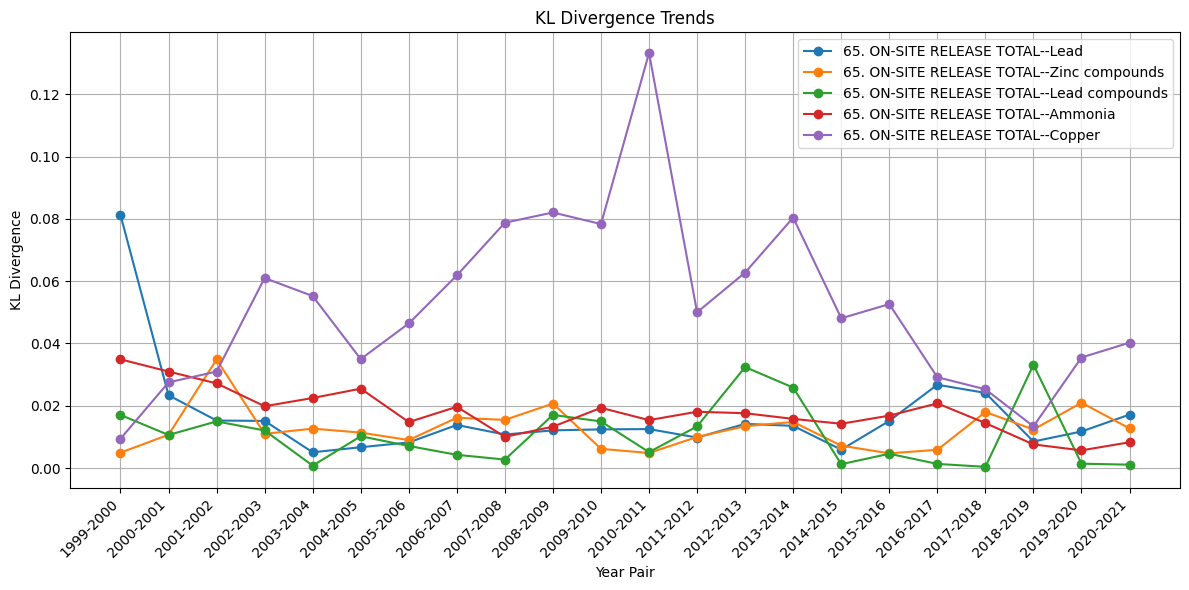

In [5]:
# Choose most populated non-metadata columns for KL Divergence:
column_counts = bladder_df.notna().sum().sort_values(ascending=False) # get and sort the count of non-Nan values for each column
exclude_cols = ['geo_code', 'year', 'county_count'] # exclude metadata columns
chemical_columns = [col for col in column_counts.index if col not in exclude_cols] # filter columns to exclude metadata columns
top_5 = chemical_columns[:5]
# print(top_5)
years = sorted(bladder_df['year'].unique()) # sort years for KL Divergence

# Store average concentrations and KL divergences
average_concentrations = {chemical: [] for chemical in top_5}
kl_divergences = {chemical: [] for chemical in top_5}
year_labels = [f"{years[i]}-{years[i+1]}" for i in range(len(years)-1)]

# Compute KL Divergence between distributions of consecutive years for each chemical
for chemical in top_5:
    print(f'\nKL Divergence for: {chemical}')

    # Prepare distributions per year
    year_distributions = {}
    for year in years:
        data = bladder_df[bladder_df['year'] == year][chemical].dropna() + 1e-9 # add small constant to avoid zeros

        # Bin the data to create a probability distribution (histogram)
        counts, bin_edges = np.histogram(data, bins=50, density=True)
        counts = counts + 1e-9  # avoid zeros
        year_distributions[year] = counts / counts.sum()  # normalize

    # Compare each pair of years consecutively
    for i in range(len(years) - 1):
        year1 = years[i]
        year2 = years[i + 1]

        p = year_distributions[year1]
        q = year_distributions[year2]

        kl_div = entropy(p, q)
        kl_divergences[chemical].append(kl_div)
        print(f'KL({year1} || {year2}): {kl_div:.4f}')

# Plot KL Divergence Trends
plt.figure(figsize=(12, 6))

for chemical in top_5:
    plt.plot(year_labels, kl_divergences[chemical], marker='o', label=chemical)

plt.title('KL Divergence Trends')
plt.xlabel('Year Pair')
plt.xticks(rotation=45, ha='right')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Lung (No Geo)

In [6]:
# load data
lung_df = pd.read_csv('lung_no_geo.csv')

# preprocess data
lung_df.drop("Unnamed: 0.1", axis=1, inplace=True)
lung_df.drop("Unnamed: 0", axis=1, inplace=True)

# show data
print(lung_df.shape)
print(lung_df.head())
print(lung_df.columns)

(72229, 729)
  geo_code  year  county_count  Barometric Pressure  CO  HAPs  Lead  NO2  \
0    01-01  1999      0.616370                  NaN NaN   NaN   NaN  NaN   
1    01-03  1999      1.973438                  NaN NaN   NaN   NaN  NaN   
2    01-05  1999      0.414127                  NaN NaN   NaN   NaN  NaN   
3    01-07  1999      0.294965                  NaN NaN   NaN   NaN  NaN   
4    01-09  1999      0.720727                  NaN NaN   NaN   NaN  NaN   

   NONOxNOy  Ozone  ...  65. ON-SITE RELEASE TOTAL--Dibutyltin dichloride  \
0       NaN    NaN  ...                                               NaN   
1       NaN    NaN  ...                                               NaN   
2       NaN    NaN  ...                                               NaN   
3       NaN    NaN  ...                                               NaN   
4       NaN    NaN  ...                                               NaN   

   65. ON-SITE RELEASE TOTAL--Formamide  \
0                       

In [7]:
# Calculate entropy for each column
entropy_dict = {}

for col in lung_df.columns:
    counts = lung_df[col].value_counts(normalize=True)
    probabilities = counts / counts.sum()
    col_entropy = entropy(probabilities, base=2)
    entropy_dict[col] = col_entropy

# convert to pandas Series for easy sorting
entropy_series = pd.Series(entropy_dict)

# top k columns with highest & lowest entropy
k = 5
top_k_high_entropy = entropy_series.sort_values(ascending=False).head(k)
top_k_low_entropy = entropy_series[entropy_series > 0].sort_values(ascending=True).head(k)

print(f"Top {k} columns with highest entropy:")
print(top_k_high_entropy)

print(f"\nTop {k} columns with lowest entropy:")
print(top_k_low_entropy)

Top 5 columns with highest entropy:
county_count                                                                                                                                     16.055323
65. ON-SITE RELEASE TOTAL--Styrene                                                                                                               13.130431
65. ON-SITE RELEASE TOTAL--Ammonia                                                                                                               12.960722
65. ON-SITE RELEASE TOTAL--Methanol                                                                                                              12.891369
65. ON-SITE RELEASE TOTAL--Hydrochloric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size)    12.845158
dtype: float64

Top 5 columns with lowest entropy:
65. ON-SITE RELEASE TOTAL--2,4-D isopropyl ester       0.353359
65. ON-SITE RELEASE TOTAL--Amitraz                     0.371232
65. ON-SIT


KL Divergence for: 65. ON-SITE RELEASE TOTAL--Lead
KL(1999 || 2000): 0.0812
KL(2000 || 2001): 0.0234
KL(2001 || 2002): 0.0153
KL(2002 || 2003): 0.0151
KL(2003 || 2004): 0.0051
KL(2004 || 2005): 0.0067
KL(2005 || 2006): 0.0082
KL(2006 || 2007): 0.0138
KL(2007 || 2008): 0.0108
KL(2008 || 2009): 0.0121
KL(2009 || 2010): 0.0124
KL(2010 || 2011): 0.0125
KL(2011 || 2012): 0.0098
KL(2012 || 2013): 0.0142
KL(2013 || 2014): 0.0136
KL(2014 || 2015): 0.0059
KL(2015 || 2016): 0.0152
KL(2016 || 2017): 0.0268
KL(2017 || 2018): 0.0241
KL(2018 || 2019): 0.0085
KL(2019 || 2020): 0.0118
KL(2020 || 2021): 0.0172

KL Divergence for: 65. ON-SITE RELEASE TOTAL--Zinc compounds
KL(1999 || 2000): 0.0050
KL(2000 || 2001): 0.0107
KL(2001 || 2002): 0.0349
KL(2002 || 2003): 0.0110
KL(2003 || 2004): 0.0127
KL(2004 || 2005): 0.0114
KL(2005 || 2006): 0.0090
KL(2006 || 2007): 0.0162
KL(2007 || 2008): 0.0155
KL(2008 || 2009): 0.0207
KL(2009 || 2010): 0.0062
KL(2010 || 2011): 0.0048
KL(2011 || 2012): 0.0100
KL(2012 || 

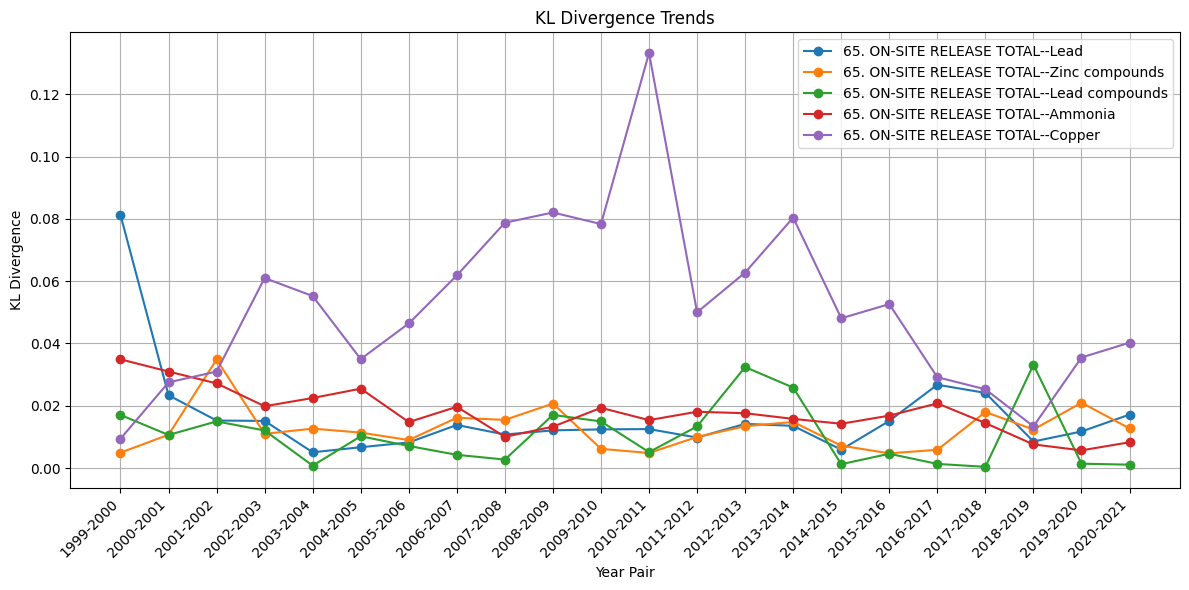

In [8]:
# Choose most populated non-metadata columns for KL Divergence:
column_counts = lung_df.notna().sum().sort_values(ascending=False) # get and sort the count of non-Nan values for each column
exclude_cols = ['geo_code', 'year', 'county_count'] # exclude metadata columns
chemical_columns = [col for col in column_counts.index if col not in exclude_cols] # filter columns to exclude metadata columns
top_5 = chemical_columns[:5]
# print(top_5)
years = sorted(lung_df['year'].unique()) # sort years for KL Divergence

# Store average concentrations and KL divergences
average_concentrations = {chemical: [] for chemical in top_5}
kl_divergences = {chemical: [] for chemical in top_5}
year_labels = [f"{years[i]}-{years[i+1]}" for i in range(len(years)-1)]

# For each chemical, compute KL Divergence between distributions of consecutive years
for chemical in top_5:
    print(f'\nKL Divergence for: {chemical}')

    # Prepare distributions per year
    year_distributions = {}
    for year in years:
        data = lung_df[lung_df['year'] == year][chemical].dropna() + 1e-9 # add small constant to avoid zeros

        # Bin the data to create a probability distribution (histogram)
        counts, bin_edges = np.histogram(data, bins=50, density=True)
        counts = counts + 1e-9  # avoid zeros
        year_distributions[year] = counts / counts.sum()  # normalize

    # Compare each pair of years consecutively
    for i in range(len(years) - 1):
        year1 = years[i]
        year2 = years[i + 1]

        p = year_distributions[year1]
        q = year_distributions[year2]

        kl_div = entropy(p, q)
        kl_divergences[chemical].append(kl_div)
        print(f'KL({year1} || {year2}): {kl_div:.4f}')

# Plot KL Divergence Trends
plt.figure(figsize=(12, 6))

for chemical in top_5:
    plt.plot(year_labels, kl_divergences[chemical], marker='o', label=chemical)

plt.title('KL Divergence Trends')
plt.xlabel('Year Pair')
plt.xticks(rotation=45, ha='right')  # rotate and align to the right
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Old Code

In [9]:
# Entropy for "geo_code" column:
geo_code_counts = lung_df['geo_code'].value_counts(normalize=True)
# print(geo_code_counts)
entropy_value = entropy(geo_code_counts, base=2)
print(f"Shannon Entropy of geo_code: {entropy_value}")

# Kullback-Leibler (KL) Divergence on PM2.5 FRM-FEM Mass column:
# create dictionary of years
years = range(min(lung_df['year']), max(lung_df['year']) + 1)
yearly_data = {year: lung_df[lung_df['year'] == year] for year in years}

# get probability distributions for PM2.5 FRM-FEM Mass
variable = 'PM2.5 FRM-FEM Mass'
yearly_distributions = {}

# drop missing values and compute normalized value counts
for year, data in yearly_data.items():
    dist = data[variable].dropna().value_counts(normalize=True)
    yearly_distributions[year] = dist

# align distributions
all_values = set()
for dist in yearly_distributions.values():
    all_values.update(dist.index)

# create df where each column is a year's distribution
dist_df = pd.DataFrame(index=sorted(all_values))
for year, dist in yearly_distributions.items():
    dist_df[year] = dist
dist_df = dist_df.fillna(0)

# compute KL Divergence between all pairs of years
kl_matrix = pd.DataFrame(index=years, columns=years, dtype=float)

for year1 in years:
    for year2 in years:
        p = dist_df[year1]
        q = dist_df[year2]
        if year1 == year2:
            kl_matrix.at[year1, year2] = 0
        else:
            kl_matrix.at[year1, year2] = entropy(p, q, base=2)

# show KL Divergence matrix
print("KL Divergence Matrix:")
print(kl_matrix)

Shannon Entropy of geo_code: 11.618884224754693
KL Divergence Matrix:
      1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  ...  2012  \
1999   0.0   inf   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
2000   inf   0.0   inf   inf   inf   inf   inf   inf   inf   inf  ...   inf   
2001   inf   inf   0.0   inf   inf   inf   inf   inf   inf   inf  ...   inf   
2002   inf   inf   inf   0.0   inf   inf   inf   inf   inf   inf  ...   inf   
2003   inf   inf   inf   inf   0.0   inf   inf   inf   inf   inf  ...   inf   
2004   inf   inf   inf   inf   inf   0.0   inf   inf   inf   inf  ...   inf   
2005   inf   inf   inf   inf   inf   inf   0.0   inf   inf   inf  ...   inf   
2006   inf   inf   inf   inf   inf   inf   inf   0.0   inf   inf  ...   inf   
2007   inf   inf   inf   inf   inf   inf   inf   inf   0.0   inf  ...   inf   
2008   inf   inf   inf   inf   inf   inf   inf   inf   inf   0.0  ...   inf   
2009   inf   inf   inf   inf   inf   inf   inf   inf   inf   